In [37]:
from linares_plot import *
import os
import statsmodels.api as sm
from joblib import Parallel, delayed
import multiprocessing

In [ ]:
numcores = multiprocessing.cpu_count() - 1
numcores

In [38]:
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def decoding_spikes_angles_err(df, size_test=0.1):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    ###Take off nans
    df = df.loc[df.iloc[:,0]<9999]
    df.columns=['spikes', 'beh', 'neuron']
    neuron_means=[]
    ### Train and test on the same neuron --> append the error of each neuron
    pop_err=[]
    
    for Neur in df.neuron.unique():
        ### same neuron 5 times --> mean value
        neur_err=[]
        for rep in range(0,5):
            spikes_train, spikes_test, beh_train, beh_test = train_test_split(df.groupby('neuron').get_group(Neur)['spikes'],
                                                                              df.groupby('neuron').get_group(Neur)['beh'],
                                                                              test_size=size_test)  

            ######## Trainning #########
            ## X matrix (intercept and spikes)
            X = np.column_stack([np.ones(np.shape(spikes_train)[0]),spikes_train])
            ## Y (sinus and cos)
            sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            Y = np.column_stack([cosinus, sinus])
            ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
            Y = Y.astype(float) #to make it work in the cluster
            X = X.astype(float)
            model = sm.OLS(Y, X)
            ##train the model
            fit=model.fit()

            ######### Testing ###########
            X = np.column_stack([np.ones(np.shape(spikes_test)[0]),spikes_test])
            p = fit.predict(X)
            x = p[:,0]
            y = p[:,1]
            #####
            ##### Error --> take the resulting vector in sin/cos space
            ### from sin and cos get the angle (-pi, pi)
            #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
            pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
            for i in range(0, len(pred_angle)):
                if pred_angle[i]<0:
                    pred_angle[i]=360+pred_angle[i]
            ##
            #error=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            error=[ circdist(beh_test.values[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            
            #low_value --> predicted positionns close to real
            neur_err.append(np.mean(error))
            ####
        
        #####       
        pop_err.append(np.mean(neur_err))
        ####
    
    return pop_err




In [50]:
path_CTD = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\CTD'


In [51]:
pfc_100 = pd.read_excel( os.path.join(path_CTD, 'pfc_100.xlsx'))
pfc_200 = pd.read_excel( os.path.join(path_CTD, 'pfc_200.xlsx'))
pfc_300 = pd.read_excel( os.path.join(path_CTD, 'pfc_300.xlsx'))
pfc_900 = pd.read_excel( os.path.join(path_CTD, 'pfc_900.xlsx'))

In [52]:
lip_100 = pd.read_excel( os.path.join(path_CTD, 'lip_100.xlsx'))
lip_200 = pd.read_excel( os.path.join(path_CTD, 'lip_200.xlsx'))
lip_300 = pd.read_excel( os.path.join(path_CTD, 'lip_300.xlsx'))
lip_900 = pd.read_excel( os.path.join(path_CTD, 'lip_900.xlsx'))

In [ ]:
### Cross temporal decoding

In [162]:
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def decoder(df_train, df_test):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    df_train.columns=['firing', 'beh']
    df_test.columns=['firing', 'beh']
    
    ## Train and test         
    activity_train= df_train.firing.values
    activity_test= df_test.firing.values
    beh_train= df_train.beh.values
    beh_test= df_test.beh.values

    ######## Trainning #########
    ## X matrix (intercept and spikes)
    X = np.column_stack([np.ones(np.shape(activity_train)[0]), activity_train])
    ## Y (sinus and cos)
    sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
    cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
    Y = np.column_stack([cosinus, sinus])
    ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
    model = sm.OLS(Y, X)
    ##train the model
    fit=model.fit()

    ######### Testing ###########
    X = np.column_stack([np.ones(np.shape(activity_test)[0]),activity_test])
    p = fit.predict(X)
    x = p[:,0]
    y = p[:,1]
    #####
    ##### Error --> take the resulting vector in sin/cos space
    ### from sin and cos get the angle (-pi, pi)
    #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
    pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
    for i in range(0, len(pred_angle)):
        if pred_angle[i]<0:
            pred_angle[i]=360+pred_angle[i]
    ##
    #
    #print(beh_test)
    error_trial=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
    mean_error = np.round(np.mean(error_trial),2)

    return mean_error


def heatmap(data, title, dist_time='None', fs1=20, fs2=12):
    ax = sns.heatmap(data,vmin=50, vmax=90, cmap= 'viridis_r',
                    cbar_kws={"shrink": .82, 'ticks' : [50, 70, 90], 'label': 'decoding error ($^\circ$)'}) ##sns.cm.rocket_r
    ax.invert_yaxis()
    ax.figure.axes[-1].yaxis.label.set_size(fs1)
    ax.figure.axes[-1].tick_params(labelsize=fs2)
    plt.gca().set_title(title, fontsize=fs1)
    plt.gca().set_xticks([0,5,10,15,20])
    plt.gca().set_xticklabels([-500,0,500,1000,1500])
    plt.gca().set_ylim(0,24)
    plt.gca().set_yticks([0,5,10,15,20])
    plt.gca().set_yticklabels([-500,0,500,1000,1500])
    plt.xticks(fontsize=fs2, rotation=0)
    plt.yticks(fontsize=fs2)
    plt.gca().set_ylabel('training time (ms)', fontsize=fs1, labelpad=12)
    plt.gca().set_xlabel('testing time (ms)', fontsize=fs1, labelpad=12)
    ##### Target presented at 500ms
    ##### Stimulus duration: 100ms
    ##### Distractor presented with different SOA
    plt.plot([500/100, 500/100], [23,23], markersize=10, color='y', marker='v')
    if dist_time != 'None':
        plt.plot([(600+dist_time)/100, (600+dist_time)/100], [23,23], markersize=10, color='r', marker='v')
                
    
    plt.show(block=False)

    

### Example 1 neuron

In [175]:
neuron_ = pfc_100.neuron.unique()[0]
print(neuron_)
## get the neuron
dfN = pfc_100.loc[pfc_100['neuron']==neuron_]
## column of times centered to stim onset
dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

#cross-decoding for 1 neuron
### empty matrix to append the cross temporal decoding
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan

### times I am interested in (no need to get more times)
dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

for training_time in list_times_sorted:
    #print(training_time)
    dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]
    dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
    paralel_train = [dfn_train for i in range(len(list_times_sorted))]
    
    paralel_test = []
    for times_testing in list_times_sorted:
        dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
        dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
        paralel_test.append(dfn_test)

    cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

    idx_append_row = np.where(training_time == all_times )[0][0]
    idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
    idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
    train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp

1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


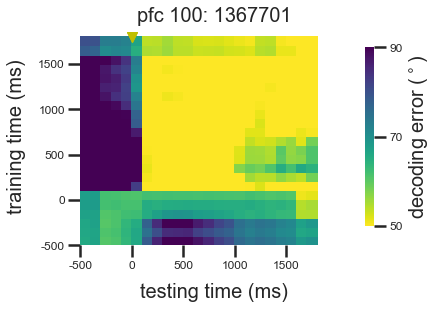

In [176]:
heatmap(train_test, 'pfc 100: ' + str(neuron_))

### All neurons in one condition

## pfc, tdoa=100

In [169]:
len(pfc_100.neuron.unique()) ##number of neurons

63

In [174]:
heatmaps_pfc_100=[]

for n_neuron,neuron_ in enumerate(pfc_100.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_100.loc[pfc_100['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_100.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


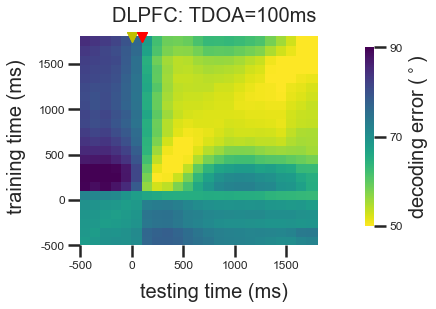

In [183]:
H = [pd.DataFrame(heatmaps_pfc_100[x]) for x in range(len(heatmaps_pfc_100))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(100)+'ms', dist_time=0)

In [184]:
heatmaps_pfc_200=[]

for n_neuron,neuron_ in enumerate(pfc_200.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_200.loc[pfc_200['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_200.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


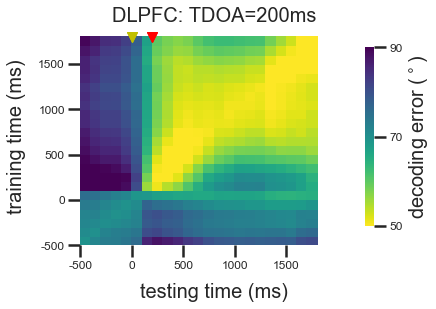

In [185]:
H = [pd.DataFrame(heatmaps_pfc_200[x]) for x in range(len(heatmaps_pfc_200))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(200)+'ms', dist_time=100)

In [186]:
heatmaps_pfc_300=[]

for n_neuron,neuron_ in enumerate(pfc_300.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_300.loc[pfc_300['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_300.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


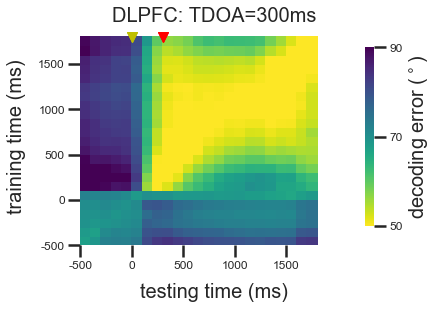

In [187]:
H = [pd.DataFrame(heatmaps_pfc_300[x]) for x in range(len(heatmaps_pfc_300))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(300)+'ms', dist_time=200)

In [188]:
heatmaps_pfc_900=[]

for n_neuron,neuron_ in enumerate(pfc_900.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_900.loc[pfc_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_900.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


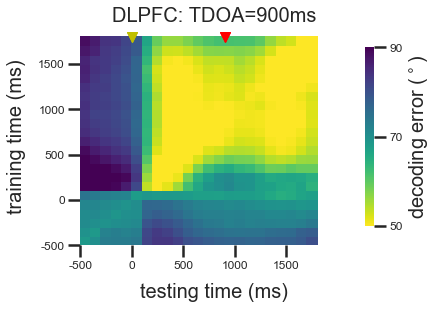

In [189]:
H = [pd.DataFrame(heatmaps_pfc_900[x]) for x in range(len(heatmaps_pfc_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(900)+'ms', dist_time=800)

In [190]:
len(lip_100.neuron.unique()) ##number of neurons

44

In [192]:
heatmaps_lip_100=[]

for n_neuron,neuron_ in enumerate(lip_100.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_100.loc[lip_100['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_100.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


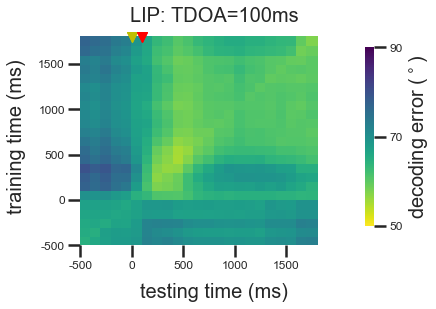

In [193]:
H = [pd.DataFrame(heatmaps_lip_100[x]) for x in range(len(heatmaps_lip_100))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(100)+'ms', dist_time=0)

In [191]:
heatmaps_lip_200=[]

for n_neuron,neuron_ in enumerate(lip_200.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_200.loc[lip_200['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_200.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


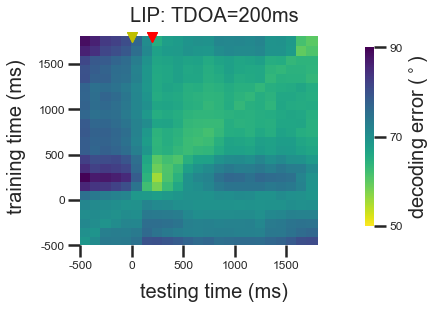

In [194]:
H = [pd.DataFrame(heatmaps_lip_200[x]) for x in range(len(heatmaps_lip_200))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(200)+'ms', dist_time=100)

In [196]:
heatmaps_lip_300=[]

for n_neuron,neuron_ in enumerate(lip_300.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_300.loc[lip_300['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_300.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


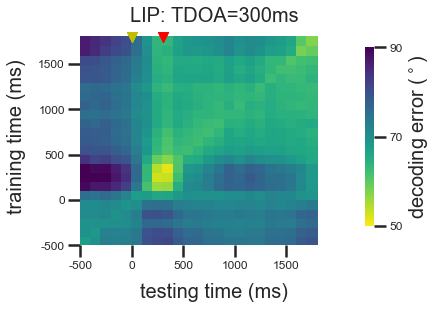

In [197]:
H = [pd.DataFrame(heatmaps_lip_300[x]) for x in range(len(heatmaps_lip_300))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(300)+'ms', dist_time=200)

In [198]:
heatmaps_lip_900=[]

for n_neuron,neuron_ in enumerate(lip_900.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_900.loc[lip_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_900.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


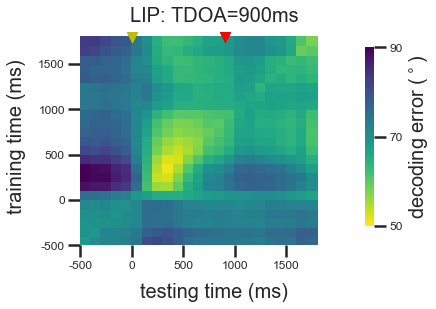

In [199]:
H = [pd.DataFrame(heatmaps_lip_900[x]) for x in range(len(heatmaps_lip_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(900)+'ms', dist_time=800)

In [ ]:
### Subpopulation analysis

In [204]:
len(heatmaps_pfc_900)

63

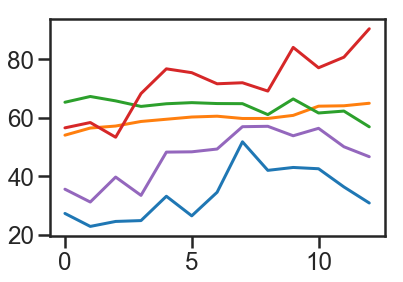

In [244]:
apps=[]
for i in range(5):
    n1 = heatmaps_pfc_900[i]
    plt.plot(n1[16, 8:21])
    apps.append(n1[16, 8:21])

([<matplotlib.axis.XTick at 0x179c49aa9e8>,
 <a list of 3 Text xticklabel objects>)

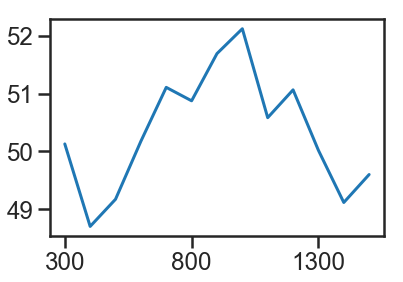

In [243]:
plt.plot(np.arange(300,1600, 100), np.mean(apps, axis=0))
plt.xticks(np.arange(300,1600, 500))

([<matplotlib.axis.XTick at 0x179c1f79390>,
 <a list of 6 Text xticklabel objects>)

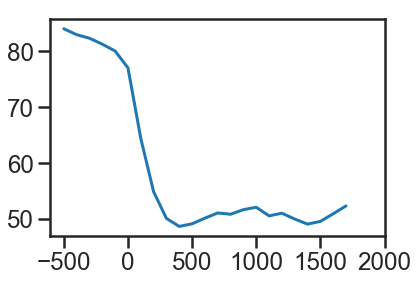

In [229]:
plt.plot(np.arange(-500,2100, 100), np.mean(apps, axis=0))
plt.xticks(np.arange(-500,2100, 500))

In [171]:
dfn_train

,firing,target_angle
4772,5.500830e-02,225
4795,5.298962e-02,225
4814,2.080248e-04,45
4840,-1.208642e-18,360
4856,6.336929e-19,225
...,...,...
7168,5.024093e-02,270
7189,2.339006e-02,270
7210,1.496089e-02,180
7231,3.682093e-02,225


In [173]:
dfn_test

,firing,target_angle
4787,2.728294e-02,225
4829,-3.203190e-18,45
4871,2.080248e-04,225
4892,3.332432e-18,270
5039,NaN,225
5123,1.077019e-20,270
5186,-6.073699e-19,225
5270,-9.860449e-19,90
5312,-5.226685e-19,90
5333,NaN,135


In [49]:
df1 = df.loc[(df['times']==500) & (df['neuron']==1367701), ['firing', 'target_angle', 'neuron']] ###tiene que ser centered!
df2 = df.loc[(df['times']==600) & (df['neuron']==1367701), ['firing', 'target_angle', 'neuron']] ###tiene que ser centered!
cross_decoding_spikes_angles_err_all(df1, df2)

[60.657331230582926]

In [ ]:
### cambiar la funcion para que sea en cada neurona (asi poder identificar subpoblaciones)
### buscar en internet como hacer eso? PCA???
### idea! tres fits diferentes! compararlos en cada neurona! :)


In [58]:
df1 = df.loc[(df['times']==500) & (df['neuron']==1367701), ['firing', 'target_angle']] ###tiene que ser centered!
df2 = df.loc[(df['times']==600) & (df['neuron']==1367701), ['firing', 'target_angle']] ###tiene que ser centered!
decoder_n(df1, df2)

60.66

In [63]:
df['times_centered'] = df['times'] - df['fixationtime']

In [64]:
df.loc[df['neuron']==1367701, ['firing', 'target_angle', 'times_centered']]

,firing,target_angle,times_centered
0,-3.637979e-19,225,-300
1,1.382432e-17,225,-200
2,1.127773e-17,225,-100
3,2.691904e-03,225,0
4,1.751611e-02,225,100
...,...,...,...
2242,1.003299e-02,315,800
2243,2.412903e-02,315,900
2244,1.087097e-02,315,1000
2245,3.434188e-06,315,1100


In [68]:
dfn = df.loc[df['neuron']==1367701]
dfn.loc[(dfn['times_centered']>-500) & (dfn['times_centered']<2000) ]
dfn.head()

,Unnamed: 0,firing,times,trial,TDOA,TDconf,targetloc,distLoc,fixationtime,failed,saccadeChoice,monkey,neuron,brain_region,rf_loc,target_angle,times_centered
0,0,-3.637979e-19,0,2,0,3,7,0,300,1,7,Mojo,1367701,DLPFC,270,225,-300
1,1,1.382432e-17,100,2,0,3,7,0,300,1,7,Mojo,1367701,DLPFC,270,225,-200
2,2,1.127773e-17,200,2,0,3,7,0,300,1,7,Mojo,1367701,DLPFC,270,225,-100
3,3,2.691904e-03,300,2,0,3,7,0,300,1,7,Mojo,1367701,DLPFC,270,225,0
4,4,1.751611e-02,400,2,0,3,7,0,300,1,7,Mojo,1367701,DLPFC,270,225,100


7

In [150]:
#cross-decoding for 1 neuron
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan


dfn = df.loc[df['neuron']==1367701]
dfn = dfn.loc[(dfn['times_centered']>=-500) & (dfn['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

for training_time in list_times_sorted:
    #print(training_time)
    dfn_train = dfn.loc[(dfn['times_centered']==training_time), ['firing', 'target_angle']]
    paralel_train = [dfn_train for i in range(len(list_times_sorted))]
    
    paralel_test = []
    for times_testing in list_times_sorted:
        dfn_test =dfn.loc[(dfn['times_centered']==times_testing), ['firing', 'target_angle']]
        paralel_test.append(dfn_test)

    cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

    idx_append_row = np.where(training_time == all_times )[0][0]
    idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
    idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
    train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp


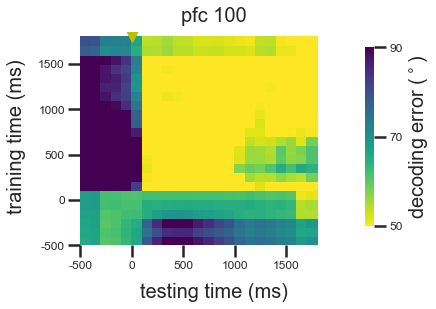

In [152]:
heatmap(train_test, 'pfc 100')

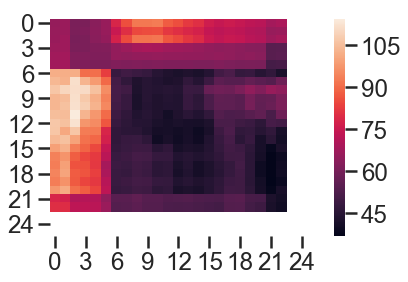

In [142]:
sns.heatmap(train_test)

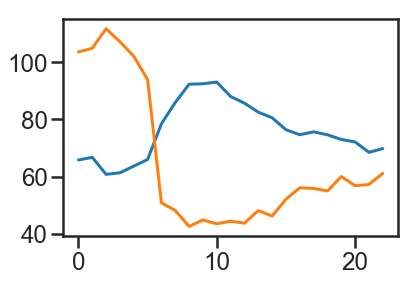

In [144]:
plt.plot(train_test[0, :])

plt.plot(train_test[9, :])

In [127]:
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan
np.shape(train_test)

(26, 26)

In [126]:
train_test

array([[65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81,
        65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81,
        65.81, 65.81, 65.81, 65.81, 65.81,   nan,   nan,   nan],
       [66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67,
        66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67,
        66.67, 66.67, 66.67, 66.67, 66.67,   nan,   nan,   nan],
       [60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58,
        60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58,
        60.58, 60.58, 60.58, 60.58, 60.58,   nan,   nan,   nan],
       [61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29,
        61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29,
        61.29, 61.29, 61.29, 61.29, 61.29,   nan,   nan,   nan],
       [61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83,
        61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83,
        61.83, 61.83, 61.83, 6

In [120]:
time_=400

In [118]:
np.arange(-500,2100, 100)

array([-500, -400, -300, -200, -100,    0,  100,  200,  300,  400,  500,
        600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600,
       1700, 1800, 1900, 2000])

In [122]:
np.where(time_ == all_times )[0][0]

9

In [117]:
dfn = df.loc[df['neuron']==1367701]
dfn = dfn.loc[(dfn['times_centered']>=-500) & (dfn['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

array([-500, -400, -300, -200, -100,    0,  100,  200,  300,  400,  500,
        600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600,
       1700], dtype=int64)

In [90]:
cross_temp = Parallel(n_jobs = numcores)(delayed(decoder_n)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)


In [97]:
train_test = np.zeros( (len(dfn.times_centered.unique()), len(dfn.times_centered.unique()) ) )


In [108]:
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan
train_test

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, na

In [102]:
dfn.times_centered.unique()

array([-300, -200, -100,    0,  100,  200,  300,  400,  500,  600,  700,
        800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, -500,
       -400, -800, -700, -600], dtype=int64)

In [91]:
cross_temp

[62.01,
 62.19,
 61.83,
 61.86,
 65.4,
 64.84,
 65.39,
 65.51,
 65.69,
 65.59,
 65.47,
 65.21,
 65.1,
 65.01,
 65.58,
 64.78,
 64.11,
 64.45,
 63.72,
 54.41,
 55.26,
 67.91,
 68.26,
 63.04,
 63.32,
 63.35]

In [79]:
cross_temp

[60.78,
 61.33,
 63.65,
 65.99,
 78.49,
 85.95,
 92.35,
 92.52,
 93.1,
 88.06,
 85.72,
 82.57,
 80.6,
 76.42,
 74.66,
 75.67,
 74.64,
 73.01,
 72.12,
 68.5,
 69.8,
 65.81,
 66.74,
 61.21,
 61.07,
 63.08]

In [ ]:
    Reconstructions = Parallel(n_jobs = numcores)(delayed(Representation)(signal, testing_angles, WM, WM_t, ref_angle=180, plot=False, intercept=Inter)  for signal in signal_paralel)    #### reconstruction standard (paralel)


In [ ]:
def cross_decoding_spikes_angles_err_all(df_train, df_test):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    ###Take off nans
    #df_train = df_train.loc[df_train.iloc[:,0]<9999]
    df_train.columns=['spikes', 'beh', 'neuron']
    #df_test = df_test.loc[df_test.iloc[:,0]<9999]
    df_test.columns=['spikes', 'beh', 'neuron']
    
    ## Train and test on the same neuron --> append the error of each neuron
    population_err=[]
    
    for Neur in df_train.neuron.unique():
        
        ### same neuron 20 times --> mean value        
        spikes_train= df_train.groupby('neuron').get_group(Neur)['spikes'].values
        spikes_test= df_test.groupby('neuron').get_group(Neur)['spikes'].values
        beh_train= df_train.groupby('neuron').get_group(Neur)['beh'].values
        beh_test= df_test.groupby('neuron').get_group(Neur)['beh'].values

        ######## Trainning #########
        ## X matrix (intercept and spikes)
        X = np.column_stack([np.ones(np.shape(spikes_train)[0]),spikes_train])
        ## Y (sinus and cos)
        sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
        cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
        Y = np.column_stack([cosinus, sinus])
        ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
        model = sm.OLS(Y, X)
        ##train the model
        fit=model.fit()

        ######### Testing ###########
        X = np.column_stack([np.ones(np.shape(spikes_test)[0]),spikes_test])
        p = fit.predict(X)
        x = p[:,0]
        y = p[:,1]
        #####
        ##### Error --> take the resulting vector in sin/cos space
        ### from sin and cos get the angle (-pi, pi)
        #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
        pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
        for i in range(0, len(pred_angle)):
            if pred_angle[i]<0:
                pred_angle[i]=360+pred_angle[i]
        ##
        #
        #print(beh_test)
        error=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]

        #low_value --> predicted positionns close to real
        population_err.append(np.mean(error))
        ######
    
    return population_err